# $0-\pi$ Qubit 
In this notebook, we use SQcircuit to find the spectrum of the $0-\pi$ Qubit based on the following paper:   
_Coherence properties of the 0-π qubit_  

First, we import the SQcircuit from circuit.py file and specify a number for each nodes on the circuit. The number for each node should be consecutive integer starts from zero(corresponds to circuit ground.) 

In [1]:
import sys, os
os.chdir("../source")
import SQcircuit as sq
import matplotlib.pyplot as plt
import numpy as np

<img src="pics/zeroPiQubit_pic1.png" width="200" />

We use Parameter Set 3 of the paper. By the following cell, we find the correspondance capacitance, inductance, and JJ energies to those values.

<img src="pics/zeroPiQubit_pic2.png" width="650" />

We create the object of SQcircuit by initializing it with `circuitParam` dictionary.

In [2]:
loop1 = sq.Loop()

C = sq.Capacitor(0.15, "GHz")
CJ = sq.Capacitor(10, "GHz")
JJ = sq.Junction(5, "GHz", loops=[loop1])
L = sq.Inductor(0.13, "GHz", loops=[loop1])

circuitElemetns = {(0, 1): [CJ, JJ],
                   (0, 2): [L],
                   (0, 3): [C],
                   (1, 2): [C],
                   (1, 3): [L],
                   (2, 3): [CJ, JJ]}

# cr is an object of Qcircuit
cr1 = sq.Circuit(circuitElemetns)

## Circuit Eigenvalues

In [3]:
cr1.setTruncationNumbers([25, 1, 25])
numEig=5
phiExt = np.linspace(0,1,100)*2*np.pi
eigenValues = np.zeros((5, len(phiExt)))
for i in range(len(phiExt)):
    loop1.setFlux(phiExt[i])
    eigenValues[:, i], _ = cr1.run(numEig)

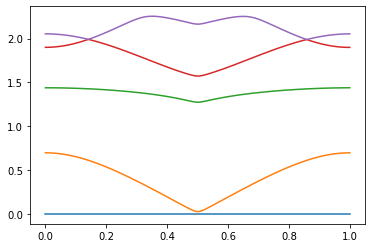

In [4]:
for i in range(numEig):
    plt.plot(phiExt/2/np.pi, eigenValues[i,:]- eigenValues[0,:])

The next cell shows the spectrum from the figure 4 of the paper, which is the same spectrum that Qcircuit calculated.

<img src="pics/zeroPiQubit_pic3.png" width="250" align = "left" />

## Circuit Eigenvectors

In [5]:
cr1.setTruncationNumbers([61, 1, 61])
loop1.setFlux(0)
eigVec, eigVal = cr1.run(numEig=2)

In [6]:
phi = np.pi*np.linspace(-1,1,100)
theta = np.pi*np.linspace(-0.3,1.3,100)
Phi, Theta = np.meshgrid(phi,theta)
state0  = np.squeeze(cr1.eigVecPhaseSpace(0,[Phi ,0 , Theta]))

Text(0, 0.5, '$\\theta$')

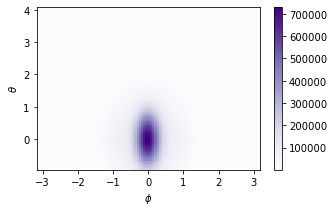

In [7]:
plt.figure(figsize=(5, 3))
plt.pcolor(Phi, Theta, np.abs(state0),cmap="Purples",shading='auto')
plt.colorbar()
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')